# Classical Kernel Methods
<a target="_blank" href="https://colab.research.google.com/github/Torben2907/qml-supervised/blob/master/tutorials/01_classical_kernel_methods.ipynbs/blob/main/notebooks/official/model_monitoring/model_monitoring.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

$\blacktriangleright$ This is the **1st** part of a notebook series documenting the workflow of the thesis and demonstrating the functionality of the <code>QMLab</code> package.

[Part 2](./02_quantum_advantage.ipynb)  &nbsp;  &nbsp; 
[Part 3](./training_quantum_kernels.ipynb)

## Overview 

1. [Introduction](#1.-Introduction)
2. [Datasets](#2.-Datasets)
3. [Kernels](#3.-Kernels)

# 1. Introduction

Support vector machines are a supervised learning algorithm. 
That means they can be used for classification and regression tasks.

Since we will work with biomedical data where the task is to predict a disease our task will be binary classification, 
e.g. we classify a person as positive with the label $+1$ and as negative with the label $-1$.

In other words we have been given data of the form 
$\left\{\left(\boldsymbol{x}^{(i)}, y^{(i)}\right)\right\}_{i=1}^m$ where $\boldsymbol{x}^{(i)} \in \mathcal{X} \subset \mathbb{R}^d$ and 
$y^{(i)} \in \mathcal{Y} = \left\{-1, +1 \right\}$. 

<div class="alert alert-block alert-info">
<b>Info: </b> m denotes the number of examples we have in our complete dataset.
</div>

An SVM then proposes a model of the form 

$$
h_{\boldsymbol{\theta}}(\boldsymbol{x}) = \langle \boldsymbol{w}, \boldsymbol{x} \rangle + b \tag{1.1}
$$

called the **hyperplane**, which can separate data linearly in the dimension of the feature space $\mathbb{R}^d$.

The representatives of each class that have the closest distance to the hyperplane are the **support vectors**.

The distance between the hyperplane and the support vectors is the **margin**.

&rarr; We're trying to find the hyperplane that separates the data while maximizing the margin.

The resulting optimization problem has an equivalent dual formulation: 
$$
h_{\bm{\theta}}(\boldsymbol{x}) = \sum_{i=1}^m \alpha_i y_i \left\langle \boldsymbol{x_i},  \boldsymbol{x} \right\rangle + b. \tag{1.2}
$$

The true power of support vector machines lays in this formulation as we are able to replace the inner product of $\mathbb{R}^d$ by the inner product of a higher dimensional Hilbert space $\mathcal{F}$: 

$$
h_{\bm{\theta}}(\boldsymbol{x}) = \sum_{i=1}^m \alpha_i y_i \left\langle\phi(\boldsymbol{x_i}),\phi(\boldsymbol{x})\right\rangle+ b. \tag{1.3}
$$

This method is called the **kernel trick**. A kernel is a bivariate, positive semi-definite function

$$
\kappa(\boldsymbol{x},\boldsymbol{x}_i) \equiv \left\langle\phi(\boldsymbol{x_i}), \phi(\boldsymbol{x})\right\rangle. \tag{1.4}
$$

The kernel trick allows us to map the data into a higher dimensional feature space before computing the dot product and therefore find non-linear decision boundaries with a linear model.

Let's try out how this works in practice, we start with some imports:

In [1]:
import numpy as np

from qmlab.preprocessing import parse_biomed_data_to_ndarray, downsample_biomed_data, upsample_biomed_data 
from qmlab.plotting import labels_pie_chart, set_plot_style
from qmlab.utils import run_cv
import matplotlib.pyplot as plt

from sklearn.svm import SVC

%matplotlib inline
plt.rcParams["figure.dpi"] = 300
set_plot_style("dark_background")

Some of the algorithms introduce randomness. To make sure that our results stay the same in between runs we define a fixed seed:

In [2]:
random_state = 42 
np.random.seed(random_state)

***

## 2. Datasets

All of the data we're working with originate from a biomedical background: 

- They are small sized, contain a large number of features and are heavily imbalanced. 
- The latter simply means that one class has way more representatives then the other class. 
- The class that has less members is the positive class.

The large amount of features will become a problem when dealing with quantum kernels later on, since most of the embeddings that have been shown to give a quantum advantage map the number of features directly to the number of qubits and it is hard to simulate more than $8$ qubits.

Therefore we start our analysis with the Haberman dataset that captures the survival status of 
breast cancer patients and has only $3$ features. 

The features are
- the age of the patient at time of surgery,
- the year of the time of surgery,
- the number of axillary lymph nodes of the patient.

We keep track of the features in a $m \times d$-dimensional real-valued matrix $\mathcal{X}$, i.e. an <code>np.ndarray</code> of shape `(m, d)`. 

The labels will be a $m$-dimensional column vector $\mathcal{Y}$, i.e. a <code>np.ndarray</code> of shape `(m,)`.

We load them via a simple function call. 

The method <code>parse_biomed_data_to_ndarray</code> will return 
$\mathcal{X}$ and $\mathcal{Y}$ as well as a <code>List[str]</code>-object 
containing all of the feature names of the dataset:

In [3]:
X, y, feature_names = parse_biomed_data_to_ndarray("haberman_new", return_X_y=True)

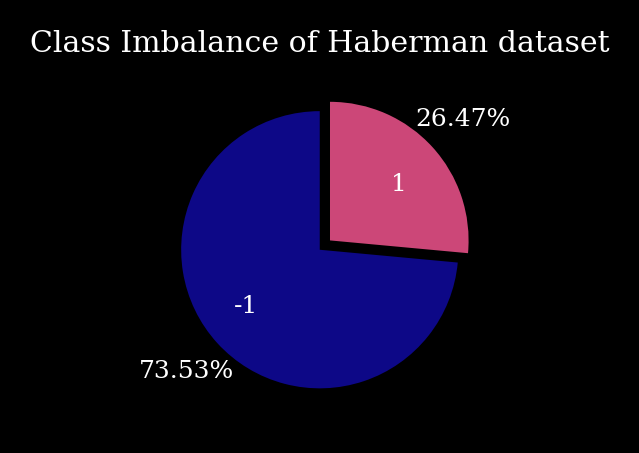

In [4]:
labels_pie_chart(y, title="Class Imbalance of Haberman dataset", figsize=(1.5, 1.5));

We can see that only 30 percent of the number of patients are tested positive with Cervical Cancer, while 
the rest is tested negative.

We define our support vector machine by calling the <code>SVC</code>-class from scikit-learn:

In [5]:
svc = SVC(kernel="linear", random_state=random_state, probability=True)

As you can see we're only using a linear kernel for now.

In [6]:
run_cv(svc, X, y, num_splits=12, random_state=random_state)

{'accuracy': {'mean': 0.7287179487179486,
  'CI': [0.7171681289397474, 0.7402677684961498]},
 'auc': {'mean': 0.6934001670843775,
  'CI': [0.6011645690758951, 0.7856357650928598]},
 'mcc': {'mean': 0.004389426988951641,
  'CI': [-0.041564167938717686, 0.05034302191662096]}}

To deal with the imbalance of the data it is common to use resampling techniques like 
**Downsampling** or **Upsampling** to create the same number of representants of each class. 


Both resampling methods come with certain advantages as well as caveats:

- Downsampling reduces the number of training examples substantially, which is an advantage regarding performance of the classifier but also comes with a loss of information due to the high imbalance to begin with.
- Upsampling will extend the number of training examples by a lot

We will investigate both Down- and Upsampling on our data and compare both methods to the imbalanced data.

In [7]:
X_down, y_down = downsample_biomed_data(X, y, random_state=random_state)

In [8]:
run_cv(svc, X_down, y_down, num_splits=5, random_state=random_state)

{'accuracy': {'mean': 0.6043560606060605,
  'CI': [0.5594977776558331, 0.6492143435562879]},
 'auc': {'mean': 0.6542049632352941,
  'CI': [0.6198603437874434, 0.6885495826831448]},
 'mcc': {'mean': 0.2426802343205424,
  'CI': [0.14578947784946134, 0.33957099079162345]}}

In [9]:
X_up, y_up = upsample_biomed_data(X, y)

In [10]:
run_cv(svc, X_up, y_up, num_splits=5, random_state=random_state)

{'accuracy': {'mean': 0.6355555555555557,
  'CI': [0.59885566648052, 0.6722554446305913]},
 'auc': {'mean': 0.7191604938271604,
  'CI': [0.6641474511026344, 0.7741735365516864]},
 'mcc': {'mean': 0.30035316788374755,
  'CI': [0.22047331886983013, 0.380233016897665]}}